In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam
from eolearn.core import EOTask, EOPatch, LinearWorkflow, EOWorkflow, Dependency, FeatureType, OverwritePermission, LoadFromDisk, SaveToDisk
from eolearn.io import S2L1CWCSInput
from eolearn.geometry import VectorToRaster

import datetime

In [3]:
from eopatches import get_bbox_splitter, get_bbox_gdf
from workflows import get_create_and_add_lpis_workflow
from plots import draw_bbox, draw_vector_timeless
from utilities import get_slovenia_crop_geopedia_idx_to_crop_id_mapping, get_group_id
from tasks import FixLPIS


C:\Users\Matej\.conda\envs\percep\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Load country

In [4]:
country = gpd.read_file('./geojson/svn_buffered.geojson')
country_shape = country.geometry.values.tolist()[-1]
country_crs = CRS.WGS84

In [5]:
number_of_squares = 3
bbox_splitter = BBoxSplitter([country_shape], country_crs, (25 * number_of_squares, 17 * number_of_squares))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, crs={'init':CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)

(13.152828941163985, 16.72778556194067, 45.29689861142602, 46.99087323095818)

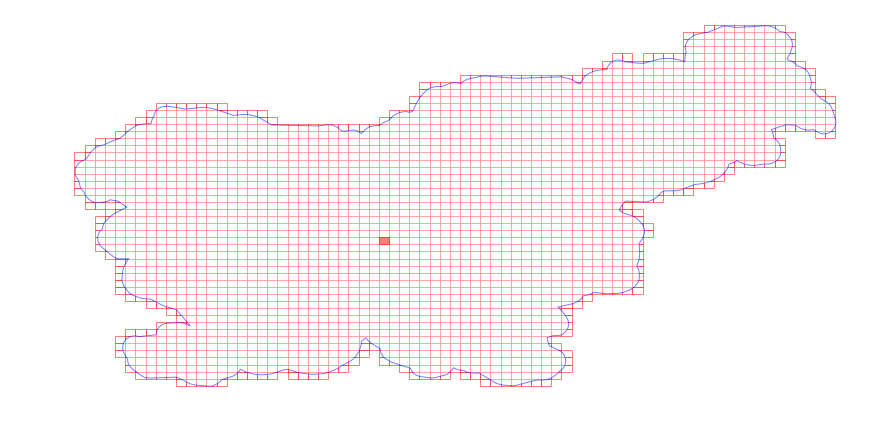

In [6]:
ids = 1000
#figure
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
gdf[ids:ids+1].plot(ax=ax,facecolor='r',edgecolor='r',alpha=0.5)

plt.axis('off')

In [7]:
gdf[10:11]

,index_x,index_y,geometry
10,1,29,"POLYGON ((13.35865977690568 46.24957061225026,..."


## Get data

In [8]:
get_slovenia_crop_geopedia_idx_to_crop_id_mapping()

,English name,Latin name,Naziv,SIFKMRS,crop_geopedia_idx
0,Niger seed,Guizotia abyssinic,abesinska gizotija,115,2
1,buckwheat,Fagopyrum esculentum),ajda,004,3
2,Egyptian clover,Trifolium alexandrinum,aleksandrijska detelja,220,4
3,amaranth,Amaranthus sp.,amarant,037,5
4,American blueberrie,,ameriška borovnica,652,6
5,American cranberries,,ameriška brusnica,681,7
6,Purple coneflower,Echinacea purpurea,ameriški slamnik,738,8
7,Chokeberries,,aronija,657,9
8,Arthichocke,Cynara scolymus,artičoka,733,10
9,Paw Paw,Asimina triloba,asimina,648,11


In [9]:
country_name = 'Slovenia'
year = 2017
out_path = './eopatches'

In [10]:
workflow_data = get_create_and_add_lpis_workflow(country_name, year, out_path)

Preparing EOWorkflow for Slovenia and year 2017:
   1. Creating empty EOPatch
   2. Adding LPIS vector data to feature LPIS_2017
      -> Geopedia layer ID: 2038
      -> with year filter applied: ('LETO', 2017)
   3. Calcuating the field area ratio
   4. Saving EOPatches to: ./eopatches/Slovenia/2017


In [11]:
tasks = workflow_data.get_tasks()
create = tasks['create']
save = tasks['save']

In [12]:
tasks

OrderedDict([('create', <tasks.CreatePatch at 0x24bbc6402e8>),
             ('add_lpis', <tasks.AddGeopediaVectorFeature at 0x24bbc640908>),
             (' area_ratio', <tasks.AddAreaRatio at 0x24bbc640be0>),
             ('save', <eolearn.core.core_tasks.SaveToDisk at 0x24bbc645f60>)])

In [13]:
bbox = np.array(bbox_list)[1000]
patch_name = 'patch'

workflow_data.execute({create:{'bbox':bbox},
                    save:{'eopatch_folder':patch_name}
                   })

WorkflowResults(
  Dependency(save):
    EOPatch(
      data: {}
      mask: {}
      scalar: {}
      label: {}
      vector: {}
      data_timeless: {}
      mask_timeless: {}
      scalar_timeless: {
        FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
      }
      label_timeless: {}
      vector_timeless: {
        LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_ID', 'SIFINFOGIS', 'SIFRA_KMRS', 'geometry'], length=605, crs=epsg:4326)
      }
      meta_info: {}
      bbox: BBox(((14.615311195118085, 45.977809978100716), (14.658644002642651, 46.00800560411733)), crs=EPSG:4326)
      timestamp: []
    )
)

In [14]:
path_out = str(out_path + '/' + country_name + '/' + str(year))
path_of_patch = str(out_path + '/' + country_name + '/' + str(year) + '/' + patch_name)
name_of_feature = 'LPIS_2017'

In [15]:
eopatch = EOPatch.load(path_of_patch)

In [16]:
eopatch.scalar_timeless['FIELD_AREA_RATIO']

array([0.19470475])

In [17]:
fields = eopatch.vector_timeless[name_of_feature]

In [18]:
fields.head(3)

,GERK_PID,GERK_POVR,KMG_MID,KRA_MEJ,LETO,POLJINA_ID,POLJ_LETO,PONO35,PONO50,POVR_POLJI,RABA_ID,SIFINFOGIS,SIFRA_KMRS,geometry
0,2586508.0,27684.1668,100359700.0,0.0,2017.0,2131377.0,2131377-2017,0.0,0.0,27684.1668,1300.0,204,157,"(POLYGON ((14.656288058 45.990359778, 14.65629..."
1,5651805.0,267.4568,100359700.0,0.0,2017.0,2131376.0,2131376-2017,0.0,0.0,267.4568,1100.0,409,86,"(POLYGON ((14.657359652 45.989784629, 14.65696..."
2,2276478.0,1338.6050,100216911.0,0.0,2017.0,2717960.0,2717960-2017,0.0,0.0,1338.6050,1300.0,204,157,"(POLYGON ((14.656870171 45.989552691, 14.65706..."


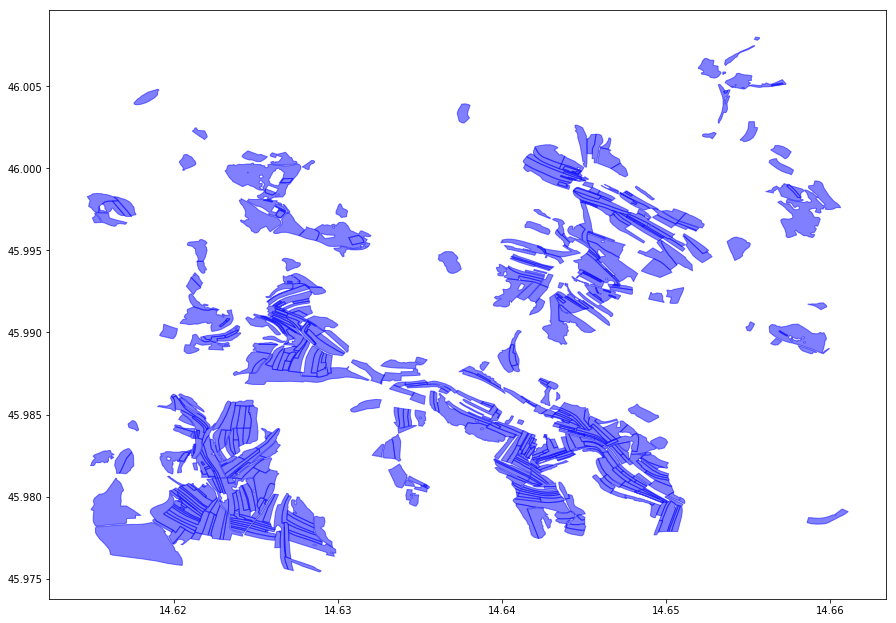

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
fields.plot(ax=ax,facecolor='b',edgecolor='b',alpha=0.5)

In [20]:
fixlpis = FixLPIS(feature=name_of_feature,country=country_name)
patch = fixlpis.execute(eopatch)

patch.vector_timeless[name_of_feature].head(3)

,GERK_PID,GERK_POVR,KMG_MID,KRA_MEJ,LETO,POLJINA_ID,POLJ_LETO,PONO35,PONO50,POVR_POLJI,RABA_ID,SIFINFOGIS,crop_geopedia_idx,geometry,English name,Latin name,Naziv,SIFKMRS
0,2586508.0,27684.1668,100359700.0,0.0,2017.0,2131377.0,2131377-2017,0.0,0.0,27684.1668,1300.0,204,157,"(POLYGON ((14.656288058 45.990359778, 14.65629...",2 times mowed meadows,,trajno travinje,204
1,2276478.0,1338.6050,100216911.0,0.0,2017.0,2717960.0,2717960-2017,0.0,0.0,1338.6050,1300.0,204,157,"(POLYGON ((14.656870171 45.989552691, 14.65706...",2 times mowed meadows,,trajno travinje,204
2,2276110.0,1900.7043,100216945.0,0.0,2017.0,2501356.0,2501356-2017,0.0,0.0,1900.7043,1300.0,204,157,"(POLYGON ((14.658636565 45.991726528, 14.65878...",2 times mowed meadows,,trajno travinje,204


## Group classes

In [21]:
slo_crop_def = pd.read_excel('./WP2/SLO_LPIS_grouping.xlsx')

In [22]:
slo_crop_def.rename(index=str, columns={"Group 1": "GROUP_1", "SIFKMRS": "CROP_ID"}, inplace=True)

In [23]:
slo_crop_def['CROP_ID'][99] = '1204'

In [24]:
slo_crops = slo_crop_def.CROP_ID.values.astype(int)
slo_groups = slo_crop_def.GROUP_1.values
slo_unique_groups = np.unique(slo_crop_def.GROUP_1.values)

In [25]:
crops_to_groups = dict(zip(slo_crops, slo_groups))

In [26]:
groups_to_number =  dict(zip(slo_unique_groups, range(len(slo_unique_groups))))

In [27]:
crops_to_number = dict(zip(slo_crops, [groups_to_number[i] for i in slo_groups]))

## Workflow all

In [28]:
tasks = workflow_data.get_tasks()
create = tasks['create']
add_lpis = tasks['add_lpis']
area_ratio = tasks[' area_ratio']
save = tasks['save']
fixlpis = FixLPIS(feature=name_of_feature,country=country_name)

add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'bands'),
    resx='10m', 
    resy='10m', 
    maxcc=0.80,
    time_difference=datetime.timedelta(days=1)
)

In [29]:
class AddGroup(EOTask):
    def __init__(self, dictionary=crops_to_number, name_of_feature='LPIS_2017'):
        self.name_of_feature = name_of_feature
        self.dictionary = crops_to_number
        
    def execute(self, eopatch):
        gdf = eopatch.vector_timeless[self.name_of_feature]
        gdf['GROUP'] = [crops_to_number[i] for i in gdf.SIFKMRS]
        eopatch.vector_timeless[self.name_of_feature] = gdf
        return eopatch
    
add_group = AddGroup()

In [30]:
rasterize = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, name_of_feature),
                           raster_feature=(FeatureType.MASK_TIMELESS, name_of_feature),
                           values=None,
                           values_column='GROUP',
                           raster_shape=(FeatureType.DATA,'bands'),
                           raster_dtype=np.int16,
                           no_data_value=np.nan            
                          )

In [31]:
workflow = LinearWorkflow(
    create,
    add_lpis,
    area_ratio,
    fixlpis,
    add_group,
    add_data,
    rasterize,
    save
)

In [32]:
bbox = np.array(bbox_list)[1000]
patch_name = 'patch'
time_interval = ['2017-01-01', '2017-12-31'] 

workflow.execute({create:{'bbox':bbox},
                  add_data:{'time_interval': time_interval},
                  save:{'eopatch_folder':patch_name}
                 })

eopatch = EOPatch.load(path_of_patch)

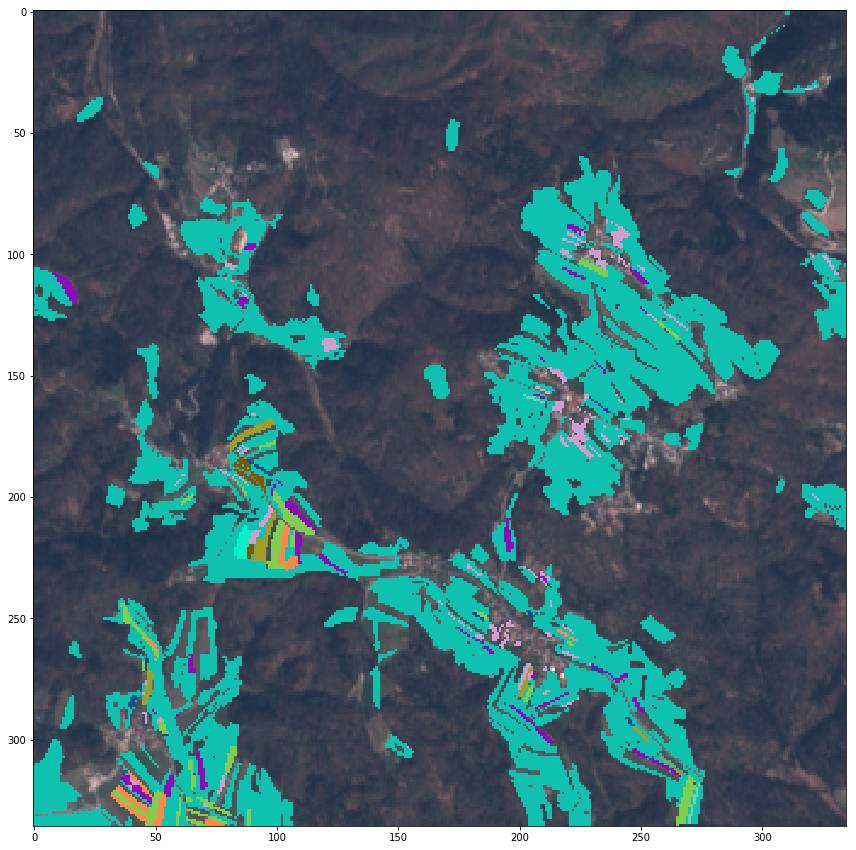

In [33]:
import matplotlib

cmap = matplotlib.colors.ListedColormap ( np.random.rand( 23,3))
#cmap = matplotlib.colors.ListedColormap(colors)

n_time = 5
image = np.clip(eopatch.data['bands'][n_time][..., [3, 2, 1]] * 3.5, 0, 1)
mask = np.squeeze(eopatch.mask_timeless[name_of_feature])

fig, ax0 = plt.subplots(figsize=(15, 15))
ax0.imshow(image)
ax0.imshow(mask, cmap=cmap, alpha=1)


In [34]:
eopatch

EOPatch(
  data: {
    bands: numpy.ndarray(shape=(38, 336, 335, 13), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(38, 336, 335, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_2017: numpy.ndarray(shape=(336, 335, 1), dtype=float64)
  }
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_ID', 'SIFINFOGIS', 'crop_geopedia_idx', 'geometry', 'English name', 'Latin name', 'Naziv', 'SIFKMRS', 'GROUP'], length=607, crs=epsg:4326)
  }
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=1)
    time_interval: ['2017-01-01', '2017-12-31']
  }
  bbox: BBox(((14.615311195118085, 45.977809978100716),